<IPython.core.display.Javascript object>


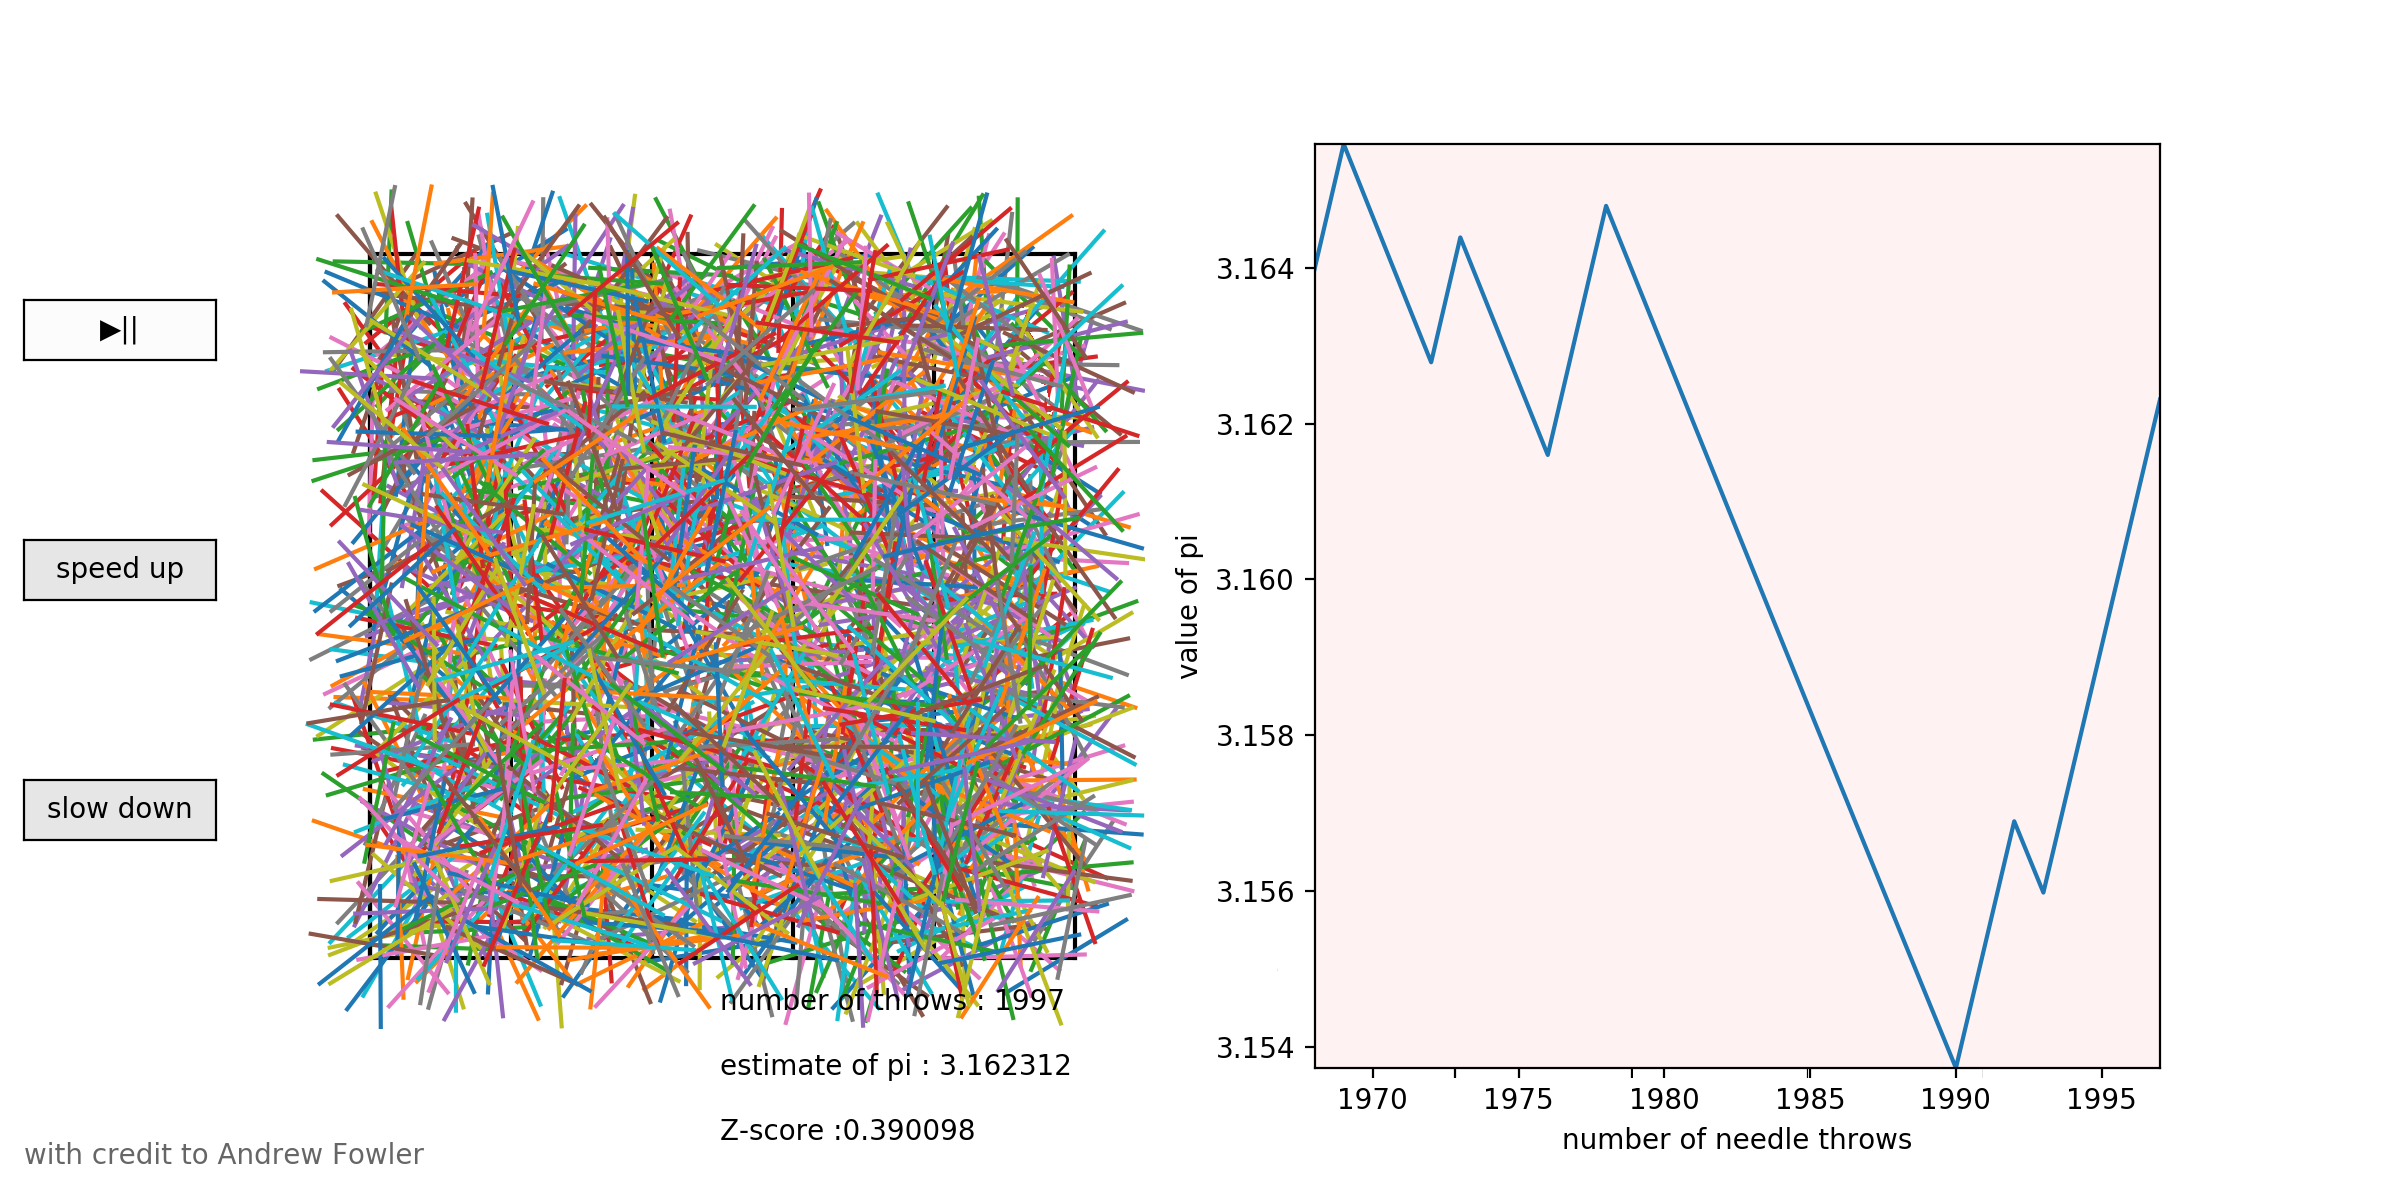

In [2]:
import numpy as np 
import matplotlib.pyplot as plt
import time
from matplotlib.widgets import Button,CheckButtons
import matplotlib.image as mpimg
%matplotlib notebook

class buffon_needle():
    def __init__(self,dx,l,throw_rate=0.1):
        """
        buffons needle experiment throws needles into a box with dimension [0,Lx] and [0,Ly] 
        
        Input
        -----
            dx : spacing between grid lines- line are positioned at i*dx for i*dx=[0,Lx]
        """
        
        self.needles = []

        # length of needle 
        self.needle_length = 2

        # number of needles crossing grid lines
        self.crossed_needles = 0.0

        # number of needles
        self.N = 0.0

        # size of box
        self.Lx = 10
        self.Ly = 10
   
        # spacing between grid lines in x
        self.dx = dx

        # time between needles throws (s)
        self.sleep = 1e-1

        # number of needles plotted at one time
        self.flush_rate = 1

        # scheme for plot
        self.colour = {"gridlines":"black","box":"black","filled_errorbar_1":"red",\
                "filled_errorbar_2":"green","reference":"red"}

        # maximum number of needles to throw
        self.max_needles = 1e6

        # array to staore pi values and their corresponding number of throws
        self.pivalues = {"needles":[],"pi":[]}

        # allow for play/pause
        self.running = False
    def crosses_grid_lines(self,needle):
        """
        use projection of needle in x to check if crosses grid lines across x
        """
        if np.floor(needle[0]/self.dx) != np.floor(needle[1]/self.dx):
            return True
        else:
            return False

    def throw_needle(self):
        """
        generate a new needle with centre [l/2 , Lx - l/2] . [l/2 , Ly - l/2]
        and orientation [0,pi)
        
        End point 1
        x = centre_x + L/2*cos(orientation)
        y = centre_y+  L/2*sin(orientation)
        
        End point 2
        x = centre_x - L/2*cos(orientation)
        y = centre_y - L/2*sin(orientation)
        """

        # needle centre
        centre_x = np.random.uniform(low=0.0,high=self.Lx)
        centre_y = np.random.uniform(low=0.0,high=self.Ly)

        # need orientation
        orientation = np.random.uniform(low=0.0,high=np.pi)
        
        # generate (x,y) coordinates of end points of needle
        x1 = centre_x + self.needle_length*0.5*np.cos(orientation)
        x2 = centre_x - self.needle_length*0.5*np.cos(orientation)
        y1 = centre_y + self.needle_length*0.5*np.sin(orientation)
        y2 = centre_y - self.needle_length*0.5*np.sin(orientation)

        # want to plot quickly
        self.needles.append([[x1,x2],[y1,y2]])

        # check if needle crossed grid lines across x
        if self.crosses_grid_lines([x1,x2]):
            self.crossed_needles += 1.0


        # count number or needles
        self.N += 1.0

        # update plot
        self.ax1.plot([x1,x2],[y1,y2])

    def pi(self):
        """
        approximation for pi = 2l *N /(t* n)

        for n grid line crosses in N total throws of the needle
        """

        return 2.0*self.needle_length*self.N/(self.dx * self.crossed_needles)    


    def update_pivalue(self):
        # clear previous axis information
        self.ax2.cla()
        self.ax2.clear()
        
        idx = min([30,len(self.pivalues["pi"])])

        if len(self.pivalues["needles"])>1:
            # set limits based upon last 30 observations of pi
            self.ax2.set_xlim(left=self.pivalues["needles"][-idx],right=self.N)
            self.ax2.set_ylim(bottom=min(self.pivalues["pi"][-idx:]),top=max(self.pivalues["pi"][-idx:]))
            
            
            # plot data
            self.ax2.plot(self.pivalues["needles"][-idx:],self.pivalues["pi"][-idx:])

            # reference
            self.ax2.plot([self.pivalues["needles"][-idx],self.N],[np.pi,np.pi],color=self.colour["reference"])
            
            # +/- 0.1
            self.ax2.fill_between([self.pivalues["needles"][-idx],self.N],[np.pi+0.1,np.pi+0.1],\
                    [np.pi-0.1,np.pi-0.1],facecolor=self.colour["filled_errorbar_1"],alpha=0.05)
            self.ax2.fill_between([self.pivalues["needles"][-idx],self.N],[np.pi+0.01,np.pi+0.01],\
                    [np.pi-0.01,np.pi-0.01],facecolor=self.colour["filled_errorbar_2"],alpha=0.10)

        self.ax2.set_xlabel('number of needle throws')
        self.ax2.set_ylabel('value of pi')

    def openview(self,fig,ax1,ax2,throw_counter_ax):
        self.fig = fig
        self.ax1 = ax1
        self.ax2 = ax2
        self.throw_counter_ax = throw_counter_ax

        # plot needles
        for _needle in self.needles:
            self.ax1.plot(_needle[0],_needle[1])

        # plot grid lines
        for ii in range(int(np.floor(self.Lx/self.dx))):
            self.ax1.plot([ii*self.dx,ii*self.dx],[0,self.Ly],color=self.colour["gridlines"])

        # draw box
        self.ax1.plot([0,0],[0,self.Ly],color=self.colour["box"])
        self.ax1.plot([self.Lx,self.Lx],[0,self.Ly],color=self.colour["box"])
        self.ax1.plot([0,self.Lx],[0,0],color=self.colour["box"])
        self.ax1.plot([0,self.Lx],[self.Ly,self.Ly],color=self.colour["box"])

        # set plot limits
        self.ax1.set_xlim(left=-self.needle_length*0.5,right=self.Lx+self.needle_length*0.5)
        self.ax1.set_ylim(bottom=-self.needle_length*0.5,top=self.Ly+self.needle_length*0.5)
        self.ax1.set_aspect('equal')

        # hide axes
        self.ax1.set_frame_on(False)
        self.ax1.axes.get_yaxis().set_visible(False)
        self.ax1.axes.get_xaxis().set_visible(False)

    def update_flushrate(self):
        """
        rate at which needles are plotted in figure
        """
        if self.sleep > 1e-2:
            self.flush_rate = 1
        elif self.sleep > 1e-3:
            self.flush_rate = 1e1
        elif self.sleep > 1e-4:
            self.flush_rate = 1e2
        else:
            self.flush_rate = 5e2

    def play_pause(self,event):
        if self.running:
            # pause simulation
            self.running = False
        else:
            # un pause
            self.running = True
            self.continue_running()

    def continue_running(self):
        while self.N<self.max_needles and self.running:
            time.sleep(self.sleep) 
            self.throw_needle()

            if np.mod(self.N,self.flush_rate)==0:
                # add current pi value
                try:
                    self.pivalues["pi"].append(self.pi())
                    self.pivalues["needles"].append(self.N)
                    self.update_pivalue()

                    # update throw counter
                    error = np.sqrt(np.pi/2.0-1.0)*np.pi/np.sqrt(self.N)
                    deviation = np.abs(self.pivalues["pi"][-1]-np.pi)
                    zscore = deviation/error
                    self.throw_counter_ax.clear()
                    self.throw_counter_ax.text(2,6,"number of throws : {:<8}\n\nestimate of pi : {:<4f}\n\nZ-score :{:<4f}".\
                            format(int(self.N),self.pivalues["pi"][-1],zscore),fontsize=10,alpha=1) 
                    
                except ZeroDivisionError:
                    pass

                # refresh plot
                self.fig.canvas.flush_events()
                self.fig.canvas.draw()

    def slowdown(self,event):
        self.sleep *= 2.0
        self.update_flushrate()
        self.continue_running()

    def speedup(self,event):
        self.sleep /= 2.0
        self.update_flushrate()
        self.continue_running()

if __name__ == "__main__":
    inst = buffon_needle(dx=2,l=2.0/3.0,throw_rate=0.1)
    
    fig,[ax1,ax2] = plt.subplots(nrows=1,ncols=2,figsize=(12,6))
    
    # choose a white image background
    fig.patch.set_facecolor('white')

    # UC logo
#    ax_logo = fig.add_axes([-0.225,0.87,0.7,0.12])
#    ax_logo.imshow(mpimg.imread('logo.png'),alpha=1)
#    ax_logo.set_aspect('equal')
#    ax_logo.axis('off')
    
    # author credit
    course_name = fig.add_axes([-0.59,-0.45,0.3,0.08])
    course_name.text(2, 6,"with credit to Andrew Fowler", fontsize=10,alpha=0.6)
    course_name.axis('off')

    # throw counter
    throw_counter = fig.add_axes([-0.3,-0.55,0.3,0.1])
    throw_counter.text(2,6,"number of throws : \n\nestimate of pi :\n\nerror estimate :",fontsize=10,alpha=1)
    throw_counter.axis('off')
    
    # initialise needle plot
    inst.openview(fig,ax1,ax2,throw_counter)

    # axes for buttons
    run_button = plt.axes([0.01,0.70,0.08,0.05])
    speedup_button = plt.axes([0.01 ,0.50,0.08,0.05])
    slowdown_button = plt.axes([0.01 ,0.30,0.08,0.05])

    # buttons
    Brun = Button(run_button,u"\u25B6"+"||",color='0.9',hovercolor='0.99')
    Bspeedup = Button(speedup_button,'speed up',color='0.9',hovercolor='0.99')
    Bslowdown = Button(slowdown_button,'slow down',color='0.9',hovercolor='0.99')

    # event handlers
    Brun.on_clicked(inst.play_pause)
    Bspeedup.on_clicked(inst.speedup)
    Bslowdown.on_clicked(inst.slowdown)

    plt.show()
